In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [33]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 30

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "tomato",
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 10000 files belonging to 10 classes.


In [7]:
class_names = dataset.class_names
class_names

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [8]:
len(dataset)

313

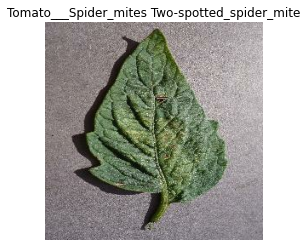

In [9]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])
    plt.axis("off")

#### 80% --> training
#### 20% --> 10% validation , 10% test

In [10]:
train_size = 0.8
dataset.take(10)
len(dataset)*train_size

250.4

In [14]:
train_ds = dataset.take(250)
len(train_ds)

250

In [15]:
test = dataset.skip(250)
len(test)

63

In [16]:
val_size = 0.1
len(dataset)*val_size

31.3

In [17]:
val_ds = test.take(31)
len(val_ds)

31

In [18]:
test_ds = test.skip(31)
len(test_ds)

32

In [19]:
def get_dataset_partitions_tf(ds, train_split= 0.8, val_split = 0.1, test_split = 0.1, shuffle = True , shuffle_size = 10000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [20]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [22]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [23]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(2.0)
])

In [29]:
input_shape_ = (BATCH_SIZE , IMAGE_SIZE , IMAGE_SIZE , CHANNELS)
n_classes = 10

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation = "relu" , input_shape = input_shape_),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = "relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = "relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = "relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = "relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = "relu"),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation = "relu"),
    layers.Dense(n_classes, activation = "softmax"),
])

model.build(input_shape=input_shape_)

In [30]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [31]:
model.compile(
    optimizer = "adam",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ["accuracy"]
)

In [34]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds,
)

Epoch 1/30
250/250 [==============================] - 533s 2s/step - loss: 1.2310 - accuracy: 0.5487 - val_loss: 1.3489 - val_accuracy: 0.5181
Epoch 2/30
250/250 [==============================] - 499s 2s/step - loss: 0.9813 - accuracy: 0.6358 - val_loss: 1.8349 - val_accuracy: 0.4627
Epoch 3/30
250/250 [==============================] - 497s 2s/step - loss: 0.8400 - accuracy: 0.6866 - val_loss: 1.2269 - val_accuracy: 0.5857
Epoch 4/30
250/250 [==============================] - 494s 2s/step - loss: 0.7658 - accuracy: 0.7202 - val_loss: 1.0815 - val_accuracy: 0.6190
Epoch 5/30
250/250 [==============================] - 492s 2s/step - loss: 0.6716 - accuracy: 0.7486 - val_loss: 1.0227 - val_accuracy: 0.6542
Epoch 6/30
250/250 [==============================] - 792s 3s/step - loss: 0.6286 - accuracy: 0.7720 - val_loss: 0.6742 - val_accuracy: 0.7419
Epoch 7/30
250/250 [==============================] - 907s 4s/step - loss: 0.5566 - accuracy: 0.7946 - val_loss: 1.4771 - val_accuracy: 0.6038

In [35]:
scores = model.evaluate(test_ds)

32/32 [==============================] - 49s 527ms/step - loss: 0.2294 - accuracy: 0.9199


In [36]:
scores

[0.2294047623872757, 0.919921875]

In [37]:
history

In [38]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 250}

In [39]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

Text(0.5, 1.0, 'Training and Validation loss')

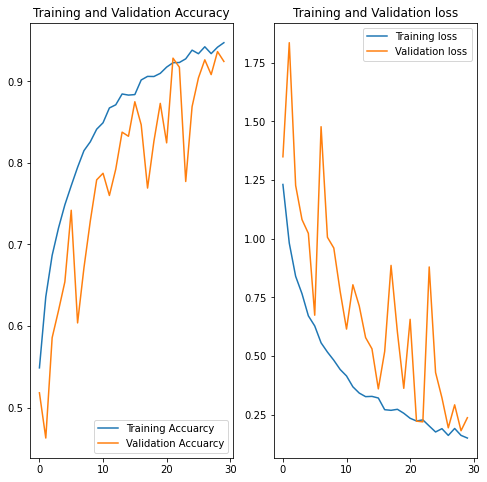

In [40]:
plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label = "Training Accuarcy")
plt.plot(range(EPOCHS), val_acc, label = "Validation Accuarcy")
plt.legend(loc = "lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label = "Training loss")
plt.plot(range(EPOCHS), val_loss, label = "Validation loss")
plt.legend(loc = "upper right")
plt.title("Training and Validation loss")

first image to predict
actual label; Tomato___Leaf_Mold
1/1 [==============================] - 1s 1s/step
predicted label: Tomato___Leaf_Mold


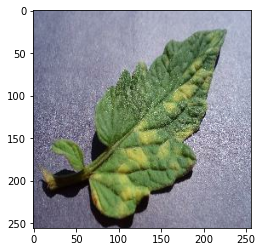

In [41]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype("uint8")
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label;", class_names[first_label])
    
    batch_prediction = model.predict(images_batch )
    print("predicted label:", class_names[np.argmax(batch_prediction[0])])

In [3]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [4]:
plt.figure(figsize = (15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

NameError: name 'test_ds' is not defined

<Figure size 1080x1080 with 0 Axes>

In [2]:
import os
model_version = max([int(i) for i in os.listdir("../saved_models") + [0]])+1
model.save(f"../saved_models/{model_version}")

NameError: name 'model' is not defined